# View HYCOM Model Data Cross Section

In [1]:
import numpy as np
import xarray as xr
import gsw
import matplotlib.pyplot as plt
from erddapClient import ERDDAP_Griddap
from scipy.spatial.distance import cdist


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from math import radians, sin, cos, sqrt, atan2
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a)) 

    # Radius of earth in kilometers is 6371
    distance = 6371* c
    return distance

In [8]:
lon1,lat1 = 300, 48.00 # Deg E and N
lon2,lat2 = 310, 54.50 # Deg E and N

remote = ERDDAP_Griddap('https://www.ncei.noaa.gov/erddap', 'HYCOM_reg1_latest3d')

# Set the result variables to 'water_temp' and 'salinity' (assuming these are the correct variable names)
remote.setResultVariables(['water_temp', 'salinity'])

# Set the subset for the desired region and time
xSubset = remote.setSubset(
    time="2023-05-15",
    depth=slice(0,5000),
    latitude=slice(lat1, lat2),
    longitude=slice(lon1, lon2)
).getxArray()

# Print the resulting xarray dataset
xSubset['longitude'] = xr.where(
    xSubset['longitude'] > 180,
    xSubset['longitude'] - 360,
    xSubset['longitude']
)

xSubset_avg = xSubset.mean(dim='time')

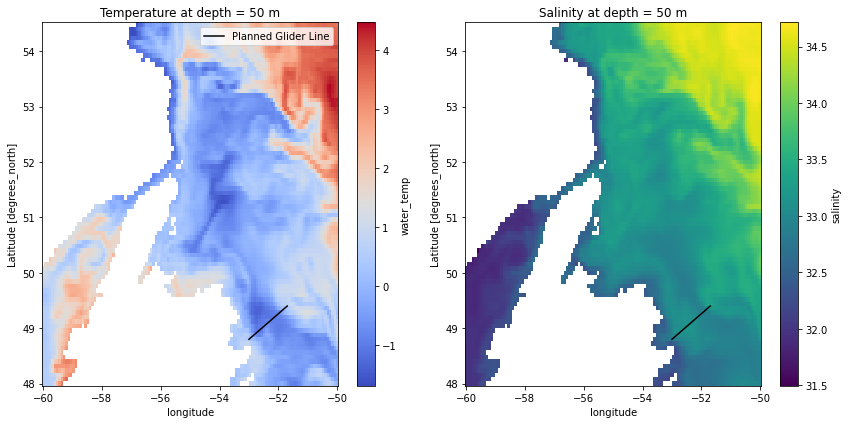

In [24]:
# Get the data

lon1,lat1 = -53.0, 48.80 # Deg E and N
lon2,lat2 = -51.7, 49.40 # Deg E and N


avg_temp = xSubset['water_temp'].mean(dim='time')
avg_salinity = xSubset['salinity'].mean(dim='time')

# Select a slice at a specific depth
slice_depth = 50  # Change this to the depth you're interested in
temp_slice = avg_temp.sel(depth=slice_depth)
salinity_slice = avg_salinity.sel(depth=slice_depth)

# Calculate min and max of the data for colorbar
vmin_temp, vmax_temp = temp_slice.min(), temp_slice.max()
vmin_salinity, vmax_salinity = salinity_slice.min(), salinity_slice.max()

# Plot the slices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot temperature slice with colorbar range set by vmin and vmax
temp_slice.plot(ax=axs[0], vmin=vmin_temp, vmax=vmax_temp, cmap='coolwarm') 
axs[0].set_title('Temperature at depth = {} m'.format(slice_depth))

# Add lon1, lat1 and lon2,lat2 as a red and blue dots
#axs[0].plot(lon1, lat1, 'ro', markersize=10, label='Point 1')
#axs[0].plot(lon2, lat2, 'bo', markersize=10, label='Point 2')
axs[0].plot([lon1, lon2], [lat1, lat2], 'k-', label='Planned Glider Line')
axs[0].legend()

# Plot salinity slice with colorbar range set by vmin and vmax
salinity_slice.plot(ax=axs[1], vmin=vmin_salinity, vmax=vmax_salinity)
axs[1].set_title('Salinity at depth = {} m'.format(slice_depth))

# Add lon1, lat1 and lon2,lat2 as a red and blue dots
#axs[1].plot(lon1, lat1, 'ro', markersize=10, label='Point 1')
#axs[1].plot(lon2, lat2, 'bo', markersize=10, label='Point 2')
axs[1].plot([lon1, lon2], [lat1, lat2], 'k-', label='Line')
plt.tight_layout()

plt.show()


In [10]:
num_points = 50 # x grid dimensions

# Define your path
lon_path = np.linspace(lon1, lon2, num_points)
lat_path = np.linspace(lat1, lat2, num_points)

# Combine your path into a single array
path = np.vstack([lat_path, lon_path]).T

# Create a meshgrid of your data's coordinates
lon_grid, lat_grid = np.meshgrid(xSubset.longitude, xSubset.latitude)

# Calculate the distances from each point in the grid to the path
distances = cdist(path, np.vstack([lat_grid.ravel(), lon_grid.ravel()]).T)

# Find the indices of the closest points in the grid to the path
indices = np.unravel_index(np.argmin(distances, axis=1), lon_grid.shape)

# Calculate the actual distances along the path
distance_path = np.array([haversine(lon_path[0], lat_path[0], lon, lat) for lon, lat in zip(lon_path, lat_path)])


# Define the depth levels based on the maximum depth
max_depth = xSubset['depth'].where(~np.isnan(xSubset['water_temp'])).max().values
depth_bin_size = 10
depth_path = np.arange(0, max_depth + depth_bin_size, depth_bin_size)

# Extract the data along the path
temp_cross_section = xSubset_avg.water_temp.isel(latitude=xr.DataArray(indices[0], dims='distance'), longitude=xr.DataArray(indices[1], dims='distance'))
salinity_cross_section = xSubset_avg.salinity.isel(latitude=xr.DataArray(indices[0], dims='distance'), longitude=xr.DataArray(indices[1], dims='distance'))

# Interpolate the data to the defined depth levels
temp_cross_section = temp_cross_section.interp(depth=depth_path)
salinity_cross_section = salinity_cross_section.interp(depth=depth_path)

# Transpose the data variables
temp_cross_section = temp_cross_section.transpose('distance', 'depth')
salinity_cross_section = salinity_cross_section.transpose('distance', 'depth')

# Create a new xarray Dataset with the cross section data
cross_section_data = xr.Dataset(
    {
        "water_temp": (("distance", "depth"), temp_cross_section.data),
        "salinity": (("distance", "depth"), salinity_cross_section.data),
    },
    coords={
        "depth": depth_path,
        "distance": distance_path,
    }
)

# Create 2D versions of lon_path and lat_path
lon_grid,depth_grid = np.meshgrid(lon_path, cross_section_data["depth"].values)
lat_grid,depth_grid = np.meshgrid(lat_path, cross_section_data["depth"].values)

# Transpose the grids to match the shape of 'salinity'
lon_grid,lat_grid,depth_grid = lon_grid.T,lat_grid.T,depth_grid.T

# Convert practical salinity (SP) to absolute salinity (SA)
SA = gsw.SA_from_SP(cross_section_data["salinity"].values, depth_grid, lon_grid, lat_grid)
cross_section_data["absolute_salinity"] = (cross_section_data["salinity"].dims, SA)

# Convert in-situ temperature (t) to conservative temperature (CT)
CT = gsw.CT_from_t(cross_section_data["absolute_salinity"].values, cross_section_data["water_temp"].values, cross_section_data["depth"].values)
cross_section_data["conservative_temperature"] = (cross_section_data["water_temp"].dims, CT)

# Calculate potential density
cross_section_data["potential_density"] = gsw.sigma0(cross_section_data["absolute_salinity"], cross_section_data["conservative_temperature"])

# Print the range of density values
print(f"Density Range: {cross_section_data['potential_density'].min().values} - {cross_section_data['potential_density'].max().values}")

Density Range: 26.06211162311706 - 27.539223011095146


In [11]:
# Load Bathymetry data
remote = ERDDAP_Griddap('https://pae-paha.pacioos.hawaii.edu/erddap/', 'srtm30plus_v11_bathy')

topo_variable = ['elev']
remote.setResultVariables(topo_variable)


# Set the subset for the desired region and time
bathy_data = remote.setSubset(
    latitude=slice(lat1-0.1, lat2+0.1),
    longitude=slice(lon1, lon2)
).getxArray()
bathy_data = bathy_data.fillna(0)


# Generate new coordinate for the path
path_coords = np.arange(len(lat_path))

# Create new coordinate arrays mapped to the path
new_latitude = xr.DataArray(lat_path, coords=[('x', path_coords)]) 
new_longitude = xr.DataArray(lon_path, coords=[('x', path_coords)]) 

# Interpolate the bathymetry data along the path
bathymetry_data = bathy_data['elev'].interp(latitude=new_latitude, longitude=new_longitude)
bathymetry_data = bathymetry_data*-1

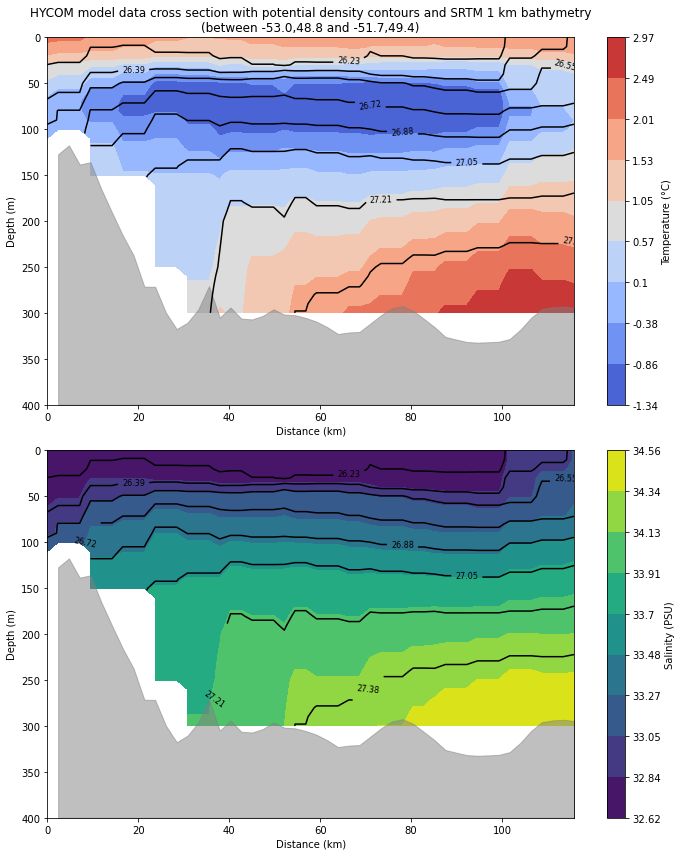

In [20]:
# Determine valid range of temperature and salinity data
valid_temp_min = np.nanmin(cross_section_data["water_temp"])
valid_temp_max = np.nanmax(cross_section_data["water_temp"])
valid_salinity_min = np.nanmin(cross_section_data["salinity"])
valid_salinity_max = np.nanmax(cross_section_data["salinity"])

#max_depth_bathy=np.max(cross_section_data["depth"].values)
max_depth_bathy=400
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the temperature section
contour_plot1 = ax1.contourf(cross_section_data["distance"], cross_section_data["depth"], cross_section_data["water_temp"].T, cmap="coolwarm", levels=np.linspace(valid_temp_min, valid_temp_max, 10))
# Add density contours
ax1.set_ylim([0, max_depth_bathy])
density_contour1 = ax1.contour(cross_section_data["distance"], cross_section_data["depth"], cross_section_data["potential_density"].T, levels=np.linspace(cross_section_data["potential_density"].min(), cross_section_data["potential_density"].max(), 10), colors="k")
ax1.clabel(density_contour1, inline=True, fontsize=8, fmt='%.2f')  # Set contour label format
cbar1 = fig.colorbar(contour_plot1, ax=ax1, label="Temperature (°C)")
cbar1.set_ticks(np.linspace(valid_temp_min, valid_temp_max, 10))
cbar1.set_ticklabels(np.round(np.linspace(valid_temp_min, valid_temp_max, 10), 2))  # Round colorbar tick labels
ax1.set_xlabel("Distance (km)")
ax1.set_ylabel("Depth (m)")
# Plot the bathymetry

ax1.fill_between(cross_section_data["distance"].values, bathymetry_data.values, y2=max_depth_bathy, color="grey", alpha=0.5)
ax1.invert_yaxis()  # To invert y-axis
ax1.set_title(f"HYCOM model data cross section with potential density contours and SRTM 1 km bathymetry\n(between {lon1},{lat1} and {lon2},{lat2})")

# Plot the salinity section
contour_plot2 = ax2.contourf(cross_section_data["distance"], cross_section_data["depth"], cross_section_data["salinity"].T, cmap="viridis", levels=np.linspace(valid_salinity_min, valid_salinity_max, 10))
# Add density contours

density_contour2 = ax2.contour(cross_section_data["distance"], cross_section_data["depth"], cross_section_data["potential_density"].T, levels=np.linspace(cross_section_data["potential_density"].min(), cross_section_data["potential_density"].max(), 10), colors="k")
ax2.clabel(density_contour2, inline=True, fontsize=8, fmt='%.2f')  # Set contour label format
cbar2 = fig.colorbar(contour_plot2, ax=ax2, label="Salinity (PSU)")
cbar2.set_ticks(np.linspace(valid_salinity_min, valid_salinity_max, 10))
cbar2.set_ticklabels(np.round(np.linspace(valid_salinity_min, valid_salinity_max, 10), 2))  # Round colorbar tick labels
ax2.set_xlabel("Distance (km)")
ax2.set_ylabel("Depth (m)")
# Plot the bathymetry
ax2.set_ylim([0, max_depth_bathy])
ax2.fill_between(cross_section_data["distance"].values, bathymetry_data.values, y2=max_depth_bathy, color="grey", alpha=0.5)
ax2.invert_yaxis()  # To invert y-axis


plt.tight_layout()  # Adjust the spacing between subplots
plt.show()
